### Imports

In [596]:
# For Docker image tensorflow/tensorflow:2.14.0-gpu-juptyer
!pip install -q nltk

In [597]:
from typing import Union
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import numpy as np
from numpy import ndarray
import tensorflow as tf
from styleformer import Styleformer

In [598]:
physical_devices = tf.config.list_physical_devices()

device_type = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

devices_to_use = [d for d in physical_devices if d.device_type == device_type]

tf.config.set_visible_devices(devices_to_use)

print("Using devices:", devices_to_use)

Using devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [599]:
# The device_name will be used in model.fit()
gpu_devices = tf.config.experimental.list_physical_devices("GPU")

if gpu_devices:
    print("GPU available, using GPU")
    tf.config.experimental.set_visible_devices(gpu_devices[0], "GPU")
    device_name = "/GPU:0"
else:
    print("GPU not available, using CPU")
    device_name = "/CPU:0"

GPU not available, using CPU


### Function for loading data set

In [601]:
class StyleTransformer:
    def transfer(self, text):
        # 假设转换逻辑是替换某些单词
        return text.replace("老", "新") 


In [602]:
def load_labels(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        labels = file.read().splitlines()
    return [int(label) for label in labels]

# 创建styler实例
styler = StyleTransformer()


### Load the text files

In [604]:
# 创建styler实例
styler = StyleTransformer()

# 确保在调用时传入styler实例
train_text_path = "/Users/xuqianlong/Downloads/train_text.txt"
train_label_path = "/Users/xuqianlong/Downloads/train_labels.txt"
test_text_path = "/Users/xuqianlong/Downloads/test_text.txt"
validation_text_path = "/Users/xuqianlong/Downloads/val_text.txt"
validation_label_path = "/Users/xuqianlong/Downloads/val_labels.txt"

train_text = load_and_style_text(train_text_path, styler)
test_text = load_and_style_text(test_text_path, styler)
validation_text = load_and_style_text(validation_text_path, styler)

# 加载和转换标签数据
train_label = load_labels(train_label_path)
test_label = load_labels(test_label_path)
validation_label = load_labels(validation_label_path)

### Preprocessing

#### Download the NLTK resources and declere global variables

In [607]:
# Set stopwords
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("vader_lexicon", quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
stopwords = set(nltk.corpus.stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Declare a dict of emojis and their corresponding sentiment
# 0: Negative; 1: Neutral; 2: Positive
emoji_dict = {
    "😊": 2,
    "😂": 2,
    "😭": 0,
    "😍": 2,
    "😘": 2,
    "😁": 2,
    "😩": 0,
    "😏": 2,
    "😉": 2,
    "😎": 2,
    "😢": 0,
    "😅": 2,
    "😱": 0,
    "😆": 2,
    "😋": 2,
    "😷": 0,
    "😔": 0,
    "😒": 0,
    "😡": 0,
    "😪": 0,
    "😤": 0,
    "😝": 2,
    "😓": 0,
    "😖": 0,
    "😣": 0,
    "😞": 0,
    "😐": 1,
    "😕": 0,
    "😫": 0,
    "😨": 0,
    "😌": 2,
    "😜": 2,
    "😑": 1,
    "😬": 0,
    "😈": 0,
    "😯": 0,
    "😳": 0,
    "😇": 2,
    "😷": 0,
    "😴": 0,
    "😲": 0,
    "😵": 0,
    "😦": 0,
    "😢": 0,
    "😮": 0,
    "😟": 0,
    "😥": 0,
    "😧": 0,
    "😰": 0,
    "😓": 0,
    "😩": 0,
    "😿": 0,
    "😾": 0,
    "🙀": 0,
    "🙅": 0,
    "🙆": 0,
    "🙇": 0,
    "🙈": 0,
    "🙉": 0,
    "🙊": 0,
    "🙋": 0,
    "🙌": 0,
    "🙍": 0,
    "🙎": 0,
    "🙏": 0,
    ":)": 2,
    ":(": 0,
    "❤️": 2,
    "👍": 2,
    "✌🏼️": 2,
    "☹️": 0,
    "🙃": 0,
    "👎": 0,
    "💙": 2,
    "💗": 2,
    "🎉": 2,
    "😄": 2,
    "🤗": 2,
    ":D": 2,
    "🎄": 2,
    "🎁": 2,
    ":/": 0,
    "?!": 0,
    ":P": 2,
    ":p": 2,
}

### Functions for preprocessing

In [609]:
def text_processing(text: list[str], data: str) -> list[list[str]]:
    """
    Process text data:
    - Remove '@user'
    - Remove hashtags
    - Remove '-'
    - Remove URLs
    - Replace emojis with their corresponding sentiment.
    - Replace punctuation marks.
    - Tokenize the text.
    - Normalize the text with nltk.
    - Lowercase the text.
    # Length of the line is added after vectorization.

    Args:
        text: list[str]: A list of text data.
        data: str: The type of data (train, test, validation).

    Returns:
        list[list[str]]: A list of list of processed text data.
    """
    processed_text = []
    for line in text:
        # Remove '@user'
        line = line.replace("@user", " ")
        # Remove hashtags
        line = line.replace("#", " ")
        # Remove '-'
        line = line.replace("-", " ")
        # Remove URLs (http, https, www)
        line = " ".join([word for word in line.split() if "http" not in word])
        line = " ".join([word for word in line.split() if "www" not in word])
        # Replace emojis with their corresponding sentiment
        line = replace_emojis(line)
        # Replace punctuation marks
        line = punctuation_replacement(line)
        # Tokenize the text.
        tokens = nltk.word_tokenize(line)
        # Normalize the text using WordNetLemmatizer and tokenize the text
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Lowercase the text
        tokens = [str(word).lower() for word in tokens]
        processed_text.append(tokens)

    return processed_text


def vectorize_text(
    input: list[list[str]], vocabulary: list[str]
) -> ndarray[ndarray[float]]:
    """
    Vectorize the text data.

    Args:
        input: list[list[str]]: A list of list of text data (Full *_text).
        vocabulary: list[str]: The list of most common words.

    Returns:
        ndarray[ndarray[float]]: A numpy array of vectorized text data.
    """
    vectorized_text = np.zeros((len(input), len(vocabulary)))
    for i, line in enumerate(input):
        for word in line:
            if word in vocabulary:
                vectorized_text[i, vocabulary.index(word)] += 1
    return vectorized_text


def map_emoji_sentiment(input: int) -> str:
    """
    Map the emoji sentiment to a string.

    Args:
        input: int: The emoji sentiment.

    Returns:
        str: The string sentiment.
    """
    if input == 0:
        return " bad "
    elif input == 1:
        return " neutral "
    elif input == 2:
        return " good "
    else:
        return " neutral "


def replace_emojis(input: str) -> str:
    """
    Replace emojis with their corresponding sentiment.
    If the emoji is 0, replace it with 'bad'.
    If the emoji is 1, replace it with 'neutral'.
    If the emoji is 2, replace it with 'good'.
    If the emoji is not in the emoji_dict, replace it with 'neutral'.

    Args:
        input: str: The input text data (line).

    Returns:
        str: The text data with emojis replaced with their corresponding sentiment.
    """
    for emoji in emoji_dict:
        if emoji in input:
            input = input.replace(emoji, map_emoji_sentiment(emoji_dict[emoji]))
    return input


def get_sentiment_score(line: list[str]) -> list[float]:
    """
    Get the sentiment score of the input text data from SentimentIntensityAnalyzer.

    Args:
        line: list[str]: The input line.

    Returns:
        list[float]: The compound score of 10 words in the sentence which has
        the most significant score (far from 0). If the sentence has less than
        10 words, the value of the remaining elements will be 0.
        After that, the score for the whole line is added to the list.
    """
    scores: list[float] = []
    analyzer = SentimentIntensityAnalyzer()
    for string in line:
        score = analyzer.polarity_scores(string)["compound"]
        scores.append(score)
    line_score = analyzer.polarity_scores(" ".join(line))["compound"]

    # Get the 10 most significant scores and add the line score
    if len(scores) > 10:
        scores.sort(key=lambda x: abs(x), reverse=True)
        result = scores[:10]
        result.append(line_score)
    else:
        result = scores
        result += [0] * (10 - len(scores))
        result.append(line_score)

    return result


def learning_rate_scheduler(epoch: int) -> float:
    """
    Learning rate scheduler, to decrease the learning rate when epoch increases.

    Args:
        epoch: int: The current epoch.

    Returns:
        float: The new learning rate.
    """
    if epoch < 10:
        return 0.0005
    elif epoch < 20:
        return 0.0003
    else:
        return 0.0001


def punctuation_replacement(line: Union[str, list[str]]) -> str:
    """
    Check if there are repeated (>= 2) punctuation marks ['.' '!', '?'] in the line.
    If there are, no matter how many times the punctuation mark is repeated,
    replace it with ['MultiDot', 'MultiExclamation', 'MultiQuestion']
    respectively.

    Replace ['.' '!', '?'] with ['Dot', 'Exclamation', 'Question'] respectively.
    If they are not repeated in the line, keep them as they are.

    Args:
        line: Union[str, list[str]]: The input line, which can be a string or a list of words.

    Returns:
        str: The line with punctuation marks replaced.
    """
    # Split the line into words if it is a string
    if type(line) is str:
        line = line.split()
    # Replace punctuation marks
    for_append = []
    for i, word in enumerate(line):
        if word.count(".") >= 2:
            line[i] = line[i].replace(".", "")
            for_append.append("MultiDot")
        elif word.count("!") >= 2:
            line[i] = line[i].replace("!", "")
            for_append.append("MultiExclamation")
        elif word.count("?") >= 2:
            line[i] = line[i].replace("?", "")
            for_append.append("MultiQuestion")
        elif word.count(".") == 1:
            line[i] = line[i].replace(".", "")
            for_append.append("Dot")
        elif word.count("!") == 1:
            line[i] = line[i].replace("!", "")
            for_append.append("Exclamation")
        elif word.count("?") == 1:
            line[i] = line[i].replace("?", "")
            for_append.append("Question")

    line += for_append

    # Join back the line
    return " ".join(line)

### Process the text data

#### Process all text data

See function docstring from text_processing()

In [612]:
train_text: list[list[str]] = text_processing(train_text, "train")
test_text: list[list[str]] = text_processing(test_text, "test")
validation_text: list[list[str]] = text_processing(validation_text, "validation")

#### Get the length of each input line

Will be added as feature

In [614]:
train_text_len: list[int] = [len(line) for line in train_text]
test_text_len: list[int] = [len(line) for line in test_text]
validation_text_len: list[int] = [len(line) for line in validation_text]

#### Remove empty lines after processing

As there may exist lines with 0 words after removing words like stopwords

In [616]:
# Find index of lists in train_text and validation_text that are empty
empty_index_train: list[int] = [i for i, x in enumerate(train_text) if not x]

# Remove empty lists from train_text and validation_text, and corresponding labels
train_text: list[list[str]] = [
    train_text[i] for i in range(len(train_text)) if i not in empty_index_train
]
train_label: list[list[str]] = [
    train_label[i] for i in range(len(train_label)) if i not in empty_index_train
]

#### Find the most common words in the training data

Will be used for vectorizing the input

In [618]:
word_frequency: dict[str, int] = {}
for line in train_text:
    for word in line:
        if word in word_frequency:
            word_frequency[word] += 1
        else:
            word_frequency[word] = 1

vocabulary: list[str] = [
    word
    for word, _ in sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[
        :10000
    ]
]

#### Get the sentiment score of the text data

Will be used as feature

In [620]:
train_sentiment_score: ndarray[ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in train_text]
)
test_sentiment_score: ndarray[ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in test_text]
)
validation_sentiment_score: ndarray[ndarray[float]] = np.array(
    [get_sentiment_score(line) for line in validation_text]
)

##### Convert the labels to integers

In [622]:
train_label: list[int] = [int(label) for label in train_label]
test_label: list[int] = [int(label) for label in test_label]
validation_label: list[int] = [int(label) for label in validation_label]

### Vectorize the input

In [624]:
# Vectorize the text data
train_vectorized: ndarray[ndarray[float]] = vectorize_text(train_text, vocabulary)
test_vectorized: ndarray[ndarray[float]] = vectorize_text(test_text, vocabulary)
validation_vectorized: ndarray[ndarray[float]] = vectorize_text(
    validation_text, vocabulary
)

#### Remove entries with all 0 vector

In [626]:
# Find the entries with all zeros in the vectorized data
zero_index_train: ndarray[int] = np.where(~train_vectorized.any(axis=1))[0]

print("Original training data size:", len(train_vectorized))

# Remove entries with all zeros in the vectorized data, and corresponding labels
train_vectorized: ndarray[ndarray[float]] = np.delete(
    train_vectorized, zero_index_train, axis=0
)
train_label: list[int] = [
    train_label[i] for i in range(len(train_label)) if i not in zero_index_train
]

# Remove entries with all zeros in the sentiment score data
train_sentiment_score: ndarray[ndarray[float]] = np.delete(
    train_sentiment_score, zero_index_train, axis=0
)

# Convert the list of text lengths to numpy array
train_text_len: ndarray[int] = np.array(train_text_len)

# Remove entries with all zeros in the text length data
train_text_len: ndarray[int] = np.delete(train_text_len, zero_index_train)

print("Processed training data size:", len(train_vectorized))

Original training data size: 45615
Processed training data size: 45614


#### Add remaining feature

In [628]:
# Add the length of the text data to the vectorized data
train_vectorized: ndarray[ndarray[float]] = np.column_stack(
    (train_vectorized, train_text_len)
)
test_vectorized: ndarray[ndarray[float]] = np.column_stack(
    (test_vectorized, test_text_len)
)
validation_vectorized: ndarray[ndarray[float]] = np.column_stack(
    (validation_vectorized, validation_text_len)
)

# Add sentiment score to each entry in the vectorized data
train_vectorized: ndarray[ndarray[float]] = np.concatenate(
    (train_vectorized, train_sentiment_score), axis=1
)
test_vectorized: ndarray[ndarray[float]] = np.concatenate(
    (test_vectorized, test_sentiment_score), axis=1
)
validation_vectorized: ndarray[ndarray[float]] = np.concatenate(
    (validation_vectorized, validation_sentiment_score), axis=1
)

#### Convert labels to one-hot encoding

For fitting into the neural network and testing

In [630]:
train_label_one_hot: ndarray[ndarray[float]] = tf.one_hot(train_label, 3)
validation_label_one_hot: ndarray[ndarray[float]] = tf.one_hot(validation_label, 3)
test_label_one_hot: ndarray[ndarray[float]] = tf.one_hot(test_label, 3)

#### Final shape of training data

In [632]:
print("Training data shape:", train_vectorized.shape)

Training data shape: (45614, 10012)


### NN

#### Setup the neural network

In [635]:

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 定义模型参数
dropout_rate = 0.5
activation_function = "relu"
epochs = 100
batch_size = 512
device_name = "/device:GPU:0" if tf.config.list_physical_devices('GPU') else "/device:CPU:0"

# 创建模型实例
model = Sequential([
    Input(shape=(train_vectorized.shape[1],)),
    Dense(2048, activation=activation_function),
    Dropout(dropout_rate),
    Dense(512, activation=activation_function),
    Dropout(dropout_rate),
    Dense(128, activation=activation_function),
    Dropout(dropout_rate),
    Dense(3, activation='softmax')
])

# 编译模型
# Compile the model
modified_adam = tf.keras.optimizers.Adam()

model.compile(
    optimizer=modified_adam, loss="categorical_crossentropy", metrics=["accuracy"]
)

# Assuming definition of learning_rate_scheduler function exists elsewhere in your code
rate_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Modified to .keras extension
]


#### Train the model

In [637]:
with tf.device(device_name):
    history = model.fit(
        train_vectorized, train_label_one_hot,
        validation_data=(validation_vectorized, validation_label_one_hot),
        epochs=epochs, batch_size=batch_size, callbacks=callbacks
    )

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.4925 - loss: 1.0131 - val_accuracy: 0.6600 - val_loss: 0.7454
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.6706 - loss: 0.7395 - val_accuracy: 0.6855 - val_loss: 0.6996
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7261 - loss: 0.6319 - val_accuracy: 0.6955 - val_loss: 0.7134
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7706 - loss: 0.5424 - val_accuracy: 0.6990 - val_loss: 0.7470
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.8261 - loss: 0.4334 - val_accuracy: 0.6565 - val_loss: 0.9342
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.8636 - loss: 0.3482 - val_accuracy: 0.6775 - val_loss: 0.9402
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.8958 - loss: 0.2695 - val_accuracy: 0.6520 - val_loss: 1.3031
Epoch 7: early stopping


#### Evaluate the model with test data

In [639]:
test_loss, test_accuracy = model.evaluate(test_vectorized, test_label_one_hot)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5524 - loss: 1.6787
Test loss: 1.717232584953308
Test accuracy: 0.5472158789634705


#### Plot graphs about loss and accuracy during epochs

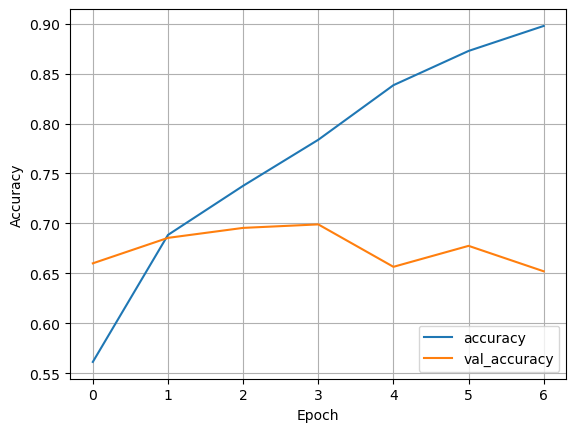

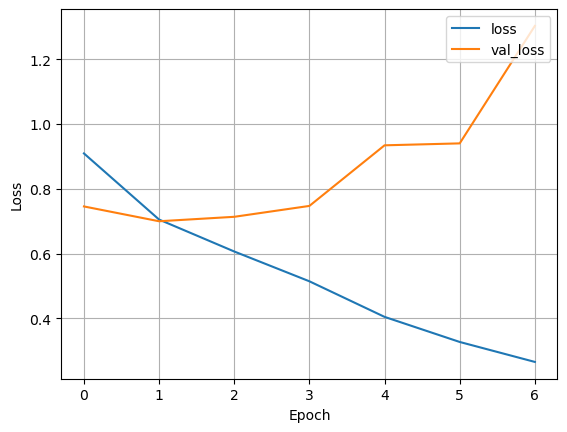

In [641]:
# Plot the training and validation accuracy
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot the training and validation loss
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [642]:
#neural_network.save('63_test.keras')

### For testing the model

Will be deleted before pushing to main

In [644]:
accuracy_list = []

for i in range(10):
    input_layer = tf.keras.layers.Input(shape=(train_vectorized.shape[1],))
    neural_network = tf.keras.models.Sequential(
        [
            input_layer,
            tf.keras.layers.Dense(2048, activation=activation_function),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(512, activation=activation_function),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(128, activation=activation_function),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(3, activation="softmax"),
        ]
    )
    neural_network.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, mode="min", verbose=1
    )
    with tf.device(device_name):
        history = neural_network.fit(
            train_vectorized,
            train_label_one_hot,
            validation_data=(validation_vectorized, validation_label_one_hot),
            epochs=200,
            batch_size=512,
            callbacks=[early_stopping, rate_scheduler],
        )
    test_loss, test_accuracy = neural_network.evaluate(test_vectorized, test_label_one_hot)
    print(i+1, test_accuracy)
    accuracy_list.append(test_accuracy)
    #if test_accuracy >= 0.641:
    #    break

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.4794 - loss: 1.0252 - val_accuracy: 0.6440 - val_loss: 0.7667 - learning_rate: 5.0000e-04
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.6444 - loss: 0.7738 - val_accuracy: 0.6955 - val_loss: 0.7035 - learning_rate: 5.0000e-04
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.7020 - loss: 0.6740 - val_accuracy: 0.6950 - val_loss: 0.7064 - learning_rate: 5.0000e-04
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.7477 - loss: 0.5949 - val_accuracy: 0.6970 - val_loss: 0.7393 - learning_rate: 5.0000e-04
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.7889 - loss: 0.5081 - val_accuracy: 0.6780 - val_loss: 0.8332 - learning_rate: 5.0000e-04
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8396 - loss: 0.3966 - val_accuracy: 0.6800 - val_loss: 0.9077 - learning_rate: 5.0000e-04
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/ste

In [645]:
print(accuracy_list)

[0.5950016379356384, 0.6142135858535767, 0.5915825366973877, 0.5759524703025818, 0.6185281872749329, 0.5915011167526245, 0.5990719795227051, 0.599723219871521, 0.605991542339325, 0.5834418535232544]


In [646]:
#neural_network.save('64_test.keras')